In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
import os

In [3]:
sns.set_theme(style="whitegrid")

In [5]:
data_dir = "data"
patient_df = pd.read_csv(os.path.join(data_dir, "patient_data.csv"))
conjoint_df = pd.read_csv(os.path.join(data_dir, "conjoint_data.csv"))
adoption_df = pd.read_csv(os.path.join(data_dir, "adoption_data.csv"))

print("Data loaded successfully.")
print(f"Patient data shape: {patient_df.shape}")
print(f"Conjoint data shape: {conjoint_df.shape}")
print(f"Adoption data shape: {adoption_df.shape}")

#%%
patient_df.head()

Data loaded successfully.
Patient data shape: (5000, 11)
Conjoint data shape: (6400, 6)
Adoption data shape: (48, 2)


,patient_id,age,comorbidity_score,time_to_treatment_days,adherence,outcome,true_segment,diagnosis_date,treatment_start_date,outcome_date,treatment_type
0,P00953,72,3.499205,96,0,0,S0,2021-06-06,2021-09-10,NaN,Drug B
1,P01107,67,3.631408,91,1,1,S0,2021-09-14,2021-12-14,2022-07-06,Drug A
2,P02461,43,1.163361,22,1,1,S2,2021-01-18,2021-02-09,2022-02-03,Drug B
3,P00627,60,3.458716,76,0,0,S0,2021-02-25,2021-05-12,NaN,Drug B
4,P03333,42,2.761556,57,0,0,S1,2021-08-08,2021-10-04,NaN,Drug B


In [7]:
avg_time_to_tx = patient_df['time_to_treatment_days'].mean()
adherence_rate = patient_df['adherence'].mean() * 100
outcome_rate = patient_df['outcome'].mean() * 100

print(f"Avg. Time to Treatment: {avg_time_to_tx:.1f} days")
print(f"Overall Adherence Rate: {adherence_rate:.1f}%")
print(f"Overall Outcome Rate: {outcome_rate:.1f}%")


Avg. Time to Treatment: 58.3 days
Overall Adherence Rate: 62.6%
Overall Outcome Rate: 66.8%


In [9]:
print("\n--- Analysis by Treatment Type ---")
journey_by_tx = patient_df.groupby('treatment_type').agg({
    'time_to_treatment_days': 'mean',
    'adherence': 'mean',
    'outcome': 'mean',
    'patient_id': 'count'
}).rename(columns={'patient_id': 'patient_count'}).reset_index()

journey_by_tx['adherence'] *= 100
journey_by_tx['outcome'] *= 100

print(journey_by_tx.to_markdown(index=False, floatfmt=(".1f", ".1f", ".1f", ".1f", ".0f")))


--- Analysis by Treatment Type ---
| treatment_type   |   time_to_treatment_days |   adherence |   outcome |   patient_count |
|:-----------------|-------------------------:|------------:|----------:|----------------:|
| Drug A           |                     57.7 |        61.8 |      67.4 |            1968 |
| Drug B           |                     59.0 |        63.0 |      67.2 |            2024 |
| Standard of Care |                     57.7 |        63.5 |      64.9 |            1008 |


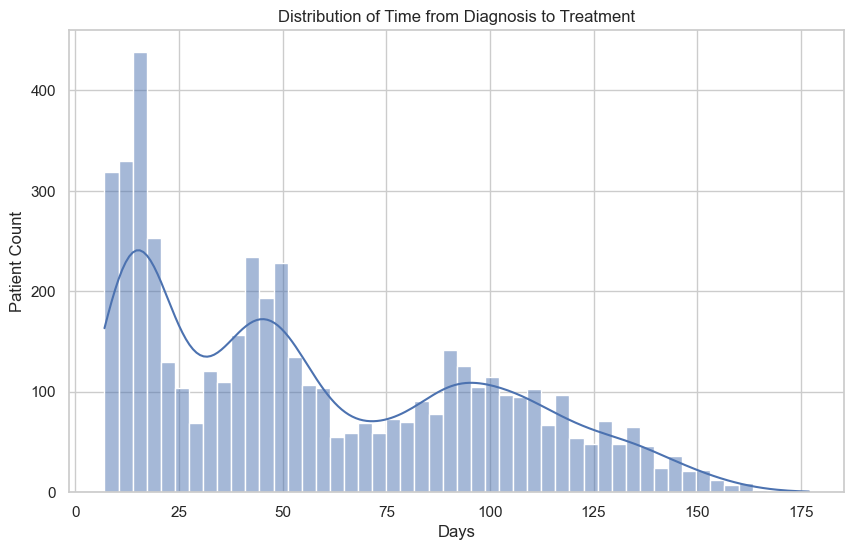

In [11]:
# --- Time-to-Treatment Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(patient_df['time_to_treatment_days'], kde=True, bins=50)
plt.title("Distribution of Time from Diagnosis to Treatment")
plt.xlabel("Days")
plt.ylabel("Patient Count")
plt.show()

In [13]:
features = ['age', 'comorbidity_score', 'time_to_treatment_days', 'adherence']
scaler = StandardScaler()
patient_df_scaled = scaler.fit_transform(patient_df[features])

print(f"Features for scaling: {features}")

Features for scaling: ['age', 'comorbidity_score', 'time_to_treatment_days', 'adherence']


In [15]:
# --- Run KMeans ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
patient_df['segment'] = kmeans.fit_predict(patient_df_scaled)
patient_df['segment'] = 'S' + patient_df['segment'].astype(str)

print(f"Segment counts:\n{patient_df['segment'].value_counts()}")


Segment counts:
segment
S0    1839
S2    1293
S1    1120
S3     748
Name: count, dtype: int64


In [21]:
print("\n--- Segment Profiles ---")
segment_profiles = patient_df.groupby('segment')[features + ['outcome']].mean()
segment_profiles['segment_size'] = patient_df['segment'].value_counts() / len(patient_df) * 100
# Re-order columns for clarity
segment_profiles = segment_profiles[['segment_size'] + features + ['outcome']]

print(segment_profiles.to_markdown(floatfmt=".2f"))

print("\n**Key Findings (example):**")
print("* Segment S0 (or equivalent): Tends to be older, high comorbidity, with low adherence and slow initiation.")
print("* Segment S2 (or equivalent): Tends to be younger, low comorbidity, with fast initiation and high outcomes.")




--- Segment Profiles ---
| segment   |   segment_size |   age |   comorbidity_score |   time_to_treatment_days |   adherence |   outcome |
|:----------|---------------:|------:|--------------------:|-------------------------:|------------:|----------:|
| S0        |          36.78 | 46.23 |                1.08 |                    22.22 |        1.00 |      0.79 |
| S1        |          22.40 | 66.24 |                3.20 |                    94.52 |        0.00 |      0.50 |
| S2        |          25.86 | 62.19 |                2.61 |                    89.86 |        1.00 |      0.64 |
| S3        |          14.96 | 51.62 |                1.70 |                    37.99 |        0.00 |      0.67 |

**Key Findings (example):**
* Segment S0 (or equivalent): Tends to be older, high comorbidity, with low adherence and slow initiation.
* Segment S2 (or equivalent): Tends to be younger, low comorbidity, with fast initiation and high outcomes.


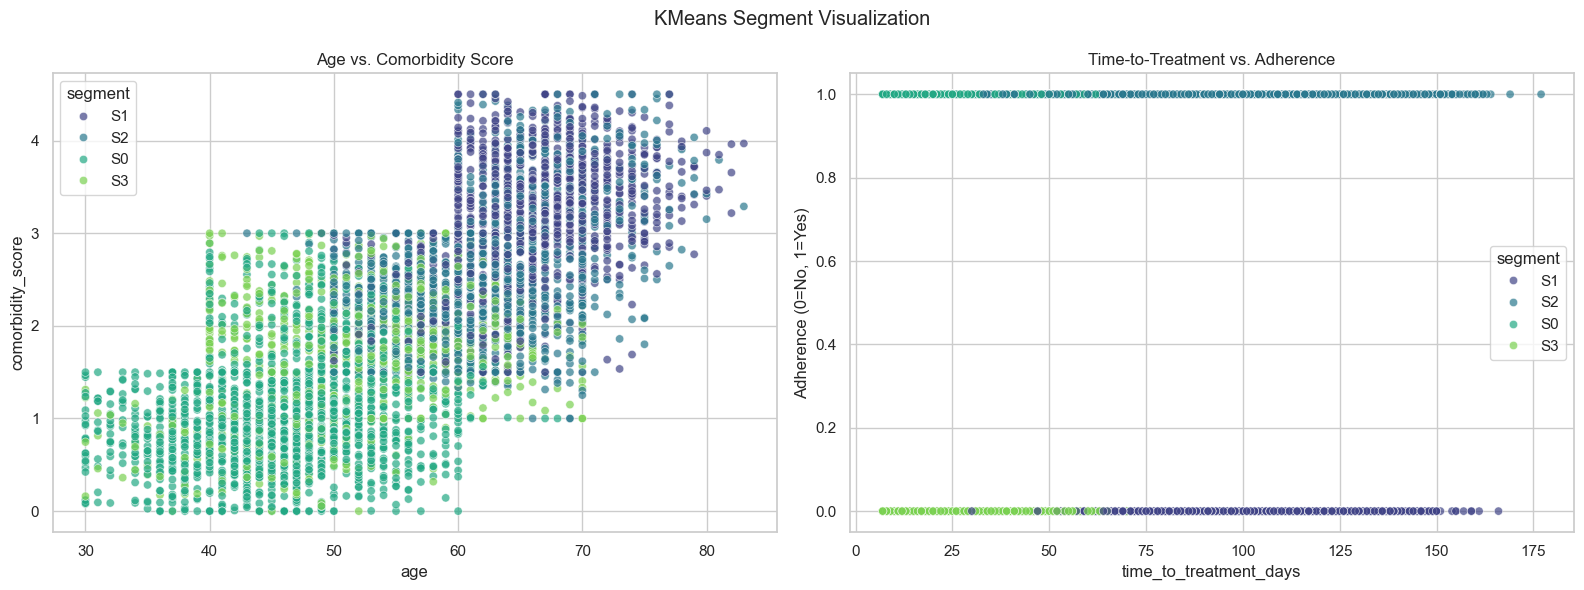

In [23]:
# --- Segment Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=patient_df, x='age', y='comorbidity_score', hue='segment', palette='viridis', ax=ax1, alpha=0.7)
ax1.set_title("Age vs. Comorbidity Score")

sns.scatterplot(data=patient_df, x='time_to_treatment_days', y='adherence', hue='segment', palette='viridis', ax=ax2, alpha=0.7)
ax2.set_title("Time-to-Treatment vs. Adherence")
ax2.set_ylabel("Adherence (0=No, 1=Yes)")

plt.suptitle("KMeans Segment Visualization")
plt.tight_layout()
plt.show()


In [33]:
conjoint_df['efficacy'] = pd.Categorical(conjoint_df['efficacy'], categories=['50% symptom reduction', '60% symptom reduction', '70% symptom reduction'], ordered=False)
conjoint_df['side_effects'] = pd.Categorical(conjoint_df['side_effects'], categories=['High', 'Medium', 'Low'], ordered=False)
conjoint_df['cost'] = pd.Categorical(conjoint_df['cost'], categories=[150, 100, 50], ordered=False)
conjoint_df['dosing'] = pd.Categorical(conjoint_df['dosing'], categories=['Daily (Pill)', 'Weekly (Injection)'], ordered=False)

# --- Define formula with reference levels ---
formula = "choice ~ C(efficacy, Treatment('50% symptom reduction')) + C(side_effects, Treatment('High')) + C(cost, Treatment(150)) + C(dosing, Treatment('Daily (Pill)'))"
print(f"Model formula:\n{formula}")

Model formula:
choice ~ C(efficacy, Treatment('50% symptom reduction')) + C(side_effects, Treatment('High')) + C(cost, Treatment(150)) + C(dosing, Treatment('Daily (Pill)'))


In [35]:
try:
    model = smf.logit(formula, data=conjoint_df).fit()
    
    print("\n--- Model Coefficients (Utilities) ---")
    print(model.summary())
    
    # --- Attribute Importance (Based on Utility Range) ---
    params = model.params
    
    # Calculate utility range for each attribute
    importance = {
        'efficacy': params.filter(like='efficacy').max() - 0, # Min is ref level (0)
        'side_effects': params.filter(like='side_effects').max() - 0,
        'cost': params.filter(like='cost').max() - 0,
        'dosing': params.filter(like='dosing').max() - 0
    }
    
    importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['Utility Range'])
    importance_df['Relative Importance %'] = (importance_df['Utility Range'] / importance_df['Utility Range'].sum()) * 100
    
    print("\n--- Attribute Importance (Based on Utility Range) ---")
    print(importance_df.sort_values('Relative Importance %', ascending=False).to_markdown(floatfmt=".2f"))

except Exception as e:
    print(f"\nAn error occurred during model fitting: {e}")

Optimization terminated successfully.
         Current function value: 0.607568
         Iterations 5

--- Model Coefficients (Utilities) ---
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                 6400
Model:                          Logit   Df Residuals:                     6392
Method:                           MLE   Df Model:                            7
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                 0.09101
Time:                        17:45:28   Log-Likelihood:                -3888.4
converged:                       True   LL-Null:                       -4277.7
Covariance Type:            nonrobust   LLR p-value:                7.656e-164
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------


--- Fitted Curve Parameters ---
Est. Market Potential (K): 48,261 adopters
Est. Adoption Rate (r):    0.251
Est. Inflection Point (t0): 18.1 months


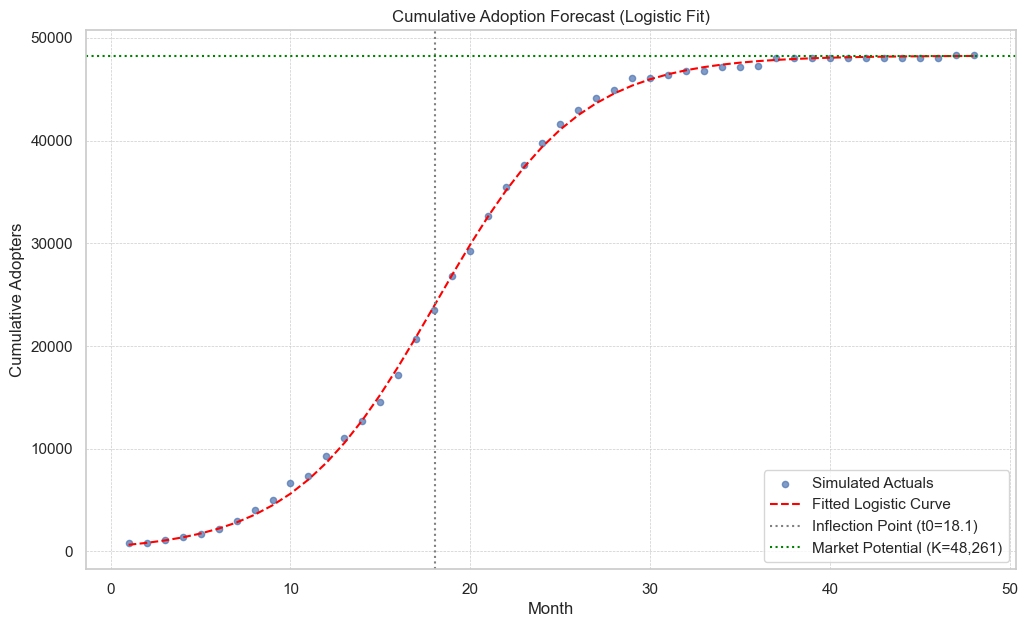

In [37]:
# --- Define the logistic function for curve fitting ---
def logistic_func(t, K, r, t0):
    """
    Logistic growth function.
    K = market potential (carrying capacity)
    r = growth rate
    t0 = inflection point (time of max growth)
    """
    return K / (1 + np.exp(-r * (t - t0)))

#%%
# --- Fit the curve ---
try:
    # Provide initial guesses
    p0 = [
        np.max(adoption_df['cumulative_adoption']), # K: guess max observed value
        0.1,                                        # r: guess small growth rate
        np.median(adoption_df['month'])             # t0: guess midpoint of time
    ]
    
    popt, pcov = curve_fit(
        logistic_func, 
        adoption_df['month'], 
        adoption_df['cumulative_adoption'], 
        p0=p0, 
        maxfev=5000
    )
    
    K_fit, r_fit, t0_fit = popt
    
    print("\n--- Fitted Curve Parameters ---")
    print(f"Est. Market Potential (K): {K_fit:,.0f} adopters")
    print(f"Est. Adoption Rate (r):    {r_fit:.3f}")
    print(f"Est. Inflection Point (t0): {t0_fit:.1f} months")

    # --- Plot the results ---
    adoption_df['forecast_fit'] = logistic_func(adoption_df['month'], K_fit, r_fit, t0_fit)
    
    plt.figure(figsize=(12, 7))
    plt.scatter(adoption_df['month'], adoption_df['cumulative_adoption'], label='Simulated Actuals', alpha=0.7, s=20)
    plt.plot(adoption_df['month'], adoption_df['forecast_fit'], label='Fitted Logistic Curve', color='red', linestyle='--')
    
    # Add annotations
    plt.axvline(t0_fit, color='gray', linestyle=':', label=f'Inflection Point (t0={t0_fit:.1f})')
    plt.axhline(K_fit, color='green', linestyle=':', label=f'Market Potential (K={K_fit:,.0f})')
    
    plt.title("Cumulative Adoption Forecast (Logistic Fit)")
    plt.xlabel("Month")
    plt.ylabel("Cumulative Adopters")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

except RuntimeError as e:
    print(f"\nError: Curve fitting failed. {e}")